# ssGSEA

Single sample GSEA (ssGSEA) is a non-parametric method that calculates a gene set enrichment score per sample as the normalized difference in empirical cumulative distribution functions (CDFs) of gene expression ranks inside and outside the gene set.

+ Author: Margaret Paiva 
+ Date:   2021-12-09  

In [62]:
suppressWarnings(require('pkgmaker',quietly = T))
require('plyr',quietly = T)
l_ply(c('dplyr',
        'data.table',
        'tidyr',  
        'tibble',
        'jsonlite', 
        'rjson',
        'httr',
        'GSVA', 
        'limma', 
        'gridExtra'), function(pkg) {
          invisible(capture.output(irequire(pkg, quiet = T, autoinstall = T)))
        })

## Expression data

Uncomment the following code to download a set of data.

In [6]:
# # In "gene_list.csv", define a list of genes of interest
# gene_list  <- as.list(read.csv("gene_list.csv")$x)

In [5]:
# # Define the data to query from API
# data  <- list("request_data_type" = "expression",
#               # If only pathway enrichment analysis is needed, you may request only one cancer type
#               # to see what pathways are enriched for a specific cancer type
#   "request_cancer_type" = c("Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", 
#                             "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"),
# #   "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
# #                       "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
# #                       "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
#   "request_genes" = gene_list,  # if a list of genes is defined in a file
#   "request_dataset" = "PDX",
#   "request_key" = "---",  # enter your token here
#   "request_client" = 99,
#   "request_user" = 1234,  # enter your user id here
#   "request_workspace_id" = "1234-99",  # enter your user id "XXXX-99"
#   "request_mode" = 'true')

In [ ]:
# # Request data from API - this may take some time
# request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/WS', 
#                   body = data, encode = 'json')
# request
# # A successful request will give "Status: 200"

In [ ]:
# # This will save the data file as a .json file in your root directory
# response <- content(request)
# response

After downloading the data, use the following to read them in.

In [2]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [3]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$model_name  <- as.character(df$model_name)
df$tumor_type  <- as.character(df$tumor_type)
df$z  <- as.numeric(df$z)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.74114899170484,-0.1693172,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
19463234,ENSG00000005243,0.43494348437293,0.799599647207579,-0.9946150,0.185174375597962,ENST00000006101:78.76% ENST00000579263:20.8%,CTG-3501,CTG-3501_Expression_1,COPZ2,CTG-3501,Breast


[1] 82800    12


In [4]:
# Pivot the data to have 'gene' as rows, 'model' as colomns, and 'log.tpm' as values
# pdx_mat <- df %>% 
#     select(c('gene', 'model', 'log.tpm'))  %>% 
#     pivot_wider(names_from = model, values_from = log.tpm)  %>% 
#     column_to_rownames('gene')
# pdx_mat  <- pdx_mat[complete.cases(pdx_mat),]  # remove rows with missing values

pdx_dat <- df %>% 
    select(c('gene', 'model_name', 'tumor_type', 'z'))
pdx_dat$z <- as.numeric(pdx_dat$z)
pdx_dat <- aggregate(pdx_dat['z'], by=pdx_dat[c('gene', 'model_name')], FUN=mean)
pdx_mat <- tidyr::pivot_wider(pdx_dat[c('z', 'gene', 'model_name')], 
                              names_from='model_name', values_from='z')
pdx_mat <- as.data.frame(pdx_mat)
rownames(pdx_mat) <- pdx_mat$gene
pdx_mat <- as.matrix(pdx_mat[-1])
pdx_mat[1:2, 1:10]
print(dim(pdx_mat))

,CTG-0009,CTG-0012,CTG-0017,CTG-0018,CTG-0019,CTG-0033,CTG-0052,CTG-0201,CTG-0202,CTG-0204
A1BG,-0.1974841,1.5956165,-0.3505304,1.322318,-0.1104276,1.005638,3.475155843,1.438267,1.3566904,1.272317
A4GALT,0.1475000,-0.2895858,-0.6772011,0.793181,-0.8565299,-1.109234,0.009585649,-1.058551,-0.8210548,-1.082000


[1] 400 207


## Gene sets from pathways

In [6]:
# This loads the variable `get_sets`
load("./requests/kegg_gene_sets.RData")

In [7]:
# get gene set for pathways
genesetfile <- tempfile()
geneset <- list()

for(set in get_sets) {
    x <- httr::GET('http://www.gsea-msigdb.org/gsea/msigdb/download_geneset.jsp',
        query=list(
            geneSetName = set,
            fileType = 'txt'
        ),
        httr::write_disk(genesetfile, overwrite = TRUE)
    )
    suppressMessages(geneset1 <- readr::read_tsv(genesetfile))
    geneset[set] <- as.list(geneset1)
#     Sys.sleep(0.5) # give the website a break
}
# first element in each geneset is a descriptor
geneset <- lapply(geneset, function(x) x[-1])

In [12]:
head(geneset, 1)

$KEGG_ABC_TRANSPORTERS
 [1] "ABCA1"  "ABCA10" "ABCA12" "ABCA13" "ABCA2"  "ABCA3"  "ABCA4"  "ABCA5" 
 [9] "ABCA6"  "ABCA7"  "ABCA8"  "ABCA9"  "ABCB1"  "ABCB10" "ABCB11" "ABCB4" 
[17] "ABCB5"  "ABCB6"  "ABCB7"  "ABCB8"  "ABCB9"  "ABCC1"  "ABCC10" "ABCC11"
[25] "ABCC12" "ABCC2"  "ABCC3"  "ABCC4"  "ABCC5"  "ABCC6"  "ABCC8"  "ABCC9" 
[33] "ABCD1"  "ABCD2"  "ABCD3"  "ABCD4"  "ABCG1"  "ABCG2"  "ABCG4"  "ABCG5" 
[41] "ABCG8"  "CFTR"   "TAP1"   "TAP2"

## ssGSEA scores

In [219]:
pdx_gsva <- GSVA::gsva(as.matrix(pdx_mat), geneset, 
                       min.sz=10, max.sz=500, method='ssgsea')
pdx_gsva
print(dim(pdx_gsva))

Estimating ssGSEA scores for 4 gene sets.
  |                                                                      |   0%Using parallel with 8 cores
  |======================================================================| 100%


,CTG-0009,CTG-0012,CTG-0017,CTG-0018,CTG-0019,CTG-0033,CTG-0052,CTG-0201,CTG-0202,CTG-0204,...,CTG-3498,CTG-3500,CTG-3501,CTG-3502,CTG-3503,CTG-3533,CTG-3537,CTG-3570,CTG-3581,CTG-3610
KEGG_ENDOCYTOSIS,-0.013696399,0.16661062,0.1127873,-0.1329063,-0.03146803,0.04713409,0.2544416,-0.01818897,-0.03838594,-0.03660919,...,0.03570144,0.04185779,0.14033395,0.002500086,-0.03195896,0.18299056,0.06764119,0.001165897,0.14448638,-0.200139200
KEGG_FOCAL_ADHESION,0.160342510,0.41598675,0.2738396,-0.1262938,-0.16903475,-0.08983858,0.3149048,0.29856033,0.38790018,0.18811588,...,0.37996325,0.09591346,0.16876891,0.251115756,-0.03251614,-0.26322671,-0.20763891,0.424770716,0.02052189,-0.001545799
KEGG_PATHWAYS_IN_CANCER,0.149187001,0.26005221,0.1446066,-0.3711191,0.01617304,-0.10333749,0.2198859,0.10979964,0.15949044,0.07639285,...,0.18356986,0.10181424,0.07523724,-0.049833494,0.03203449,0.09142723,0.07598851,0.180064351,-0.01190224,0.069583165
KEGG_REGULATION_OF_ACTIN_CYTOSKELETON,0.005913819,0.09199468,0.2080648,-0.2272912,0.05944449,-0.02312019,0.2759348,-0.01856954,0.10803574,0.12737931,...,0.10010841,0.04818373,0.21643349,0.075111983,0.03550157,0.30515004,-0.03024186,0.107809348,0.17359573,0.066135840


[1]   4 207


## Plotting

In [200]:
cancertype <- cancertype[order(cancertype[,'tumor_type']),]
cancertype <- cancertype[cancertype[,'model_name'] %in% colnames(pdx_gsva),]
cancertype[,'tumor_type'] <- as.factor(cancertype[,'tumor_type'])
# cluster gene sets
rw_d <- dist(pdx_gsva)
rw_cl <- hclust(rw_d)
pdx_gsva <- pdx_gsva[rw_cl$order, ]
col_d <- dist(t(pdx_gsva))
col_cl <- hclust(col_d)
pdx_cl <- pdx_gsva[, col_cl$order] 
# cluster samples
col_d <- dist(t(pdx_gsva))
col_cl <- hclust(col_d)
pdx_cl <- pdx_gsva[, col_cl$order]
rownames(cancertype) <- cancertype[,'model_name']
cancertype <- cancertype[colnames(pdx_cl),]

In [229]:
pdx_dat <- df %>% 
    select(c('gene', 'model_name', 'tumor_type', 'z'))
cancertype <- unique(pdx_dat[c('model_name', 'tumor_type')])
cancertype <- cancertype[order(cancertype[,'tumor_type']),]
cancertype <- cancertype[cancertype[,'model_name'] %in% colnames(pdx_gsva),]
cancertype[,'tumor_type'] <- as.factor(cancertype[,'tumor_type'])
pdx_gsva <- pdx_gsva[, cancertype$model_name]
pdx_cl <- copy(pdx_gsva)

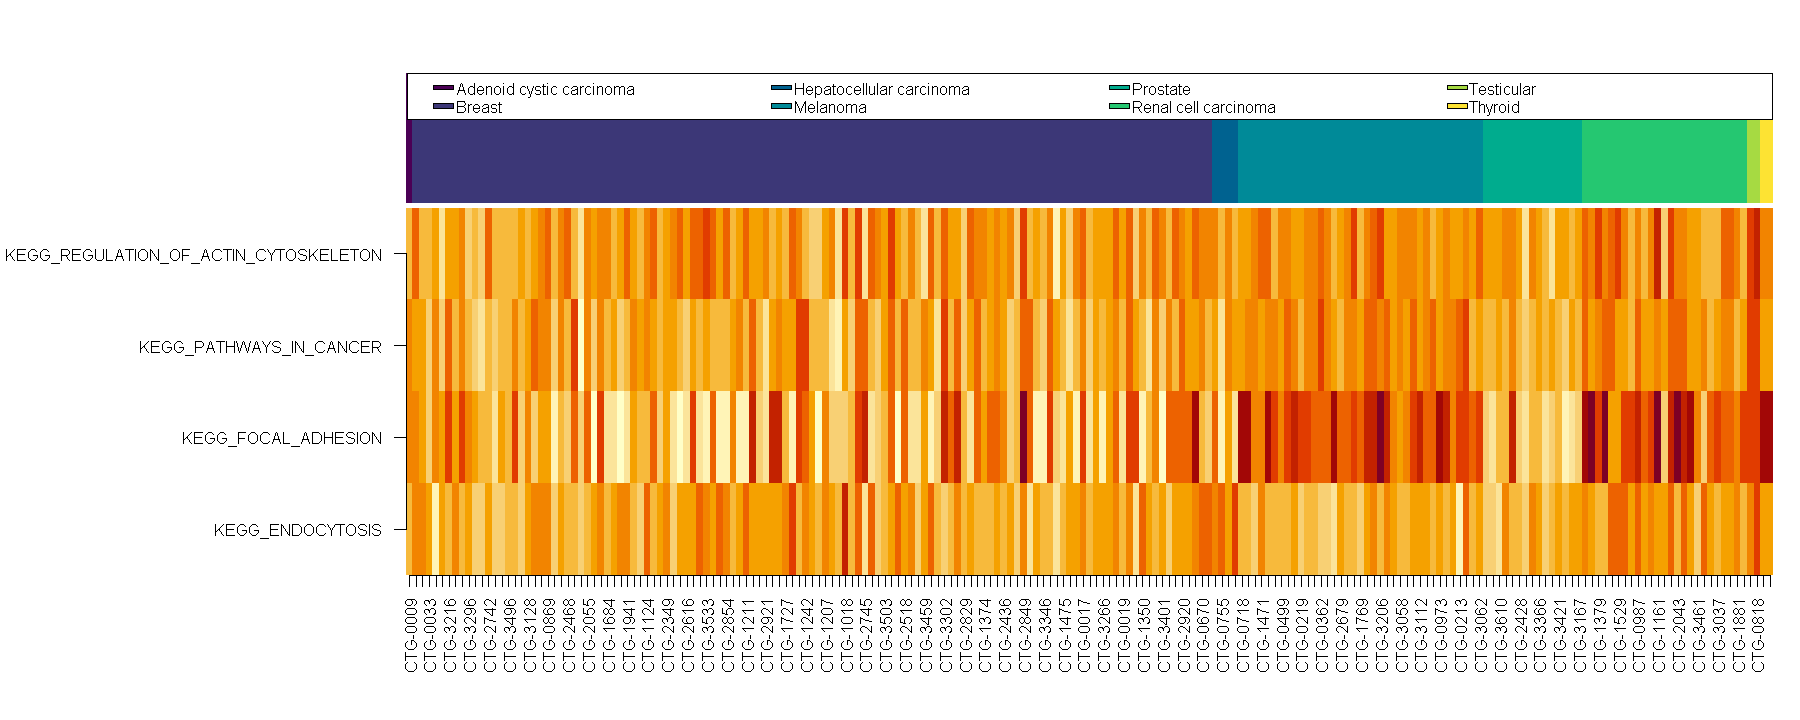

In [231]:
# Change plot size
options(repr.plot.width=10, repr.plot.height=4, repr.plot.res=180)
# layout our plot
graphics::layout(
    matrix(c(1, 1, 2, 2, 2, 2, 2), nrow = 7))

colorLegend <- hcl.colors(length(unique(cancertype$tumor_type)), "viridis")
par(mar=c(0,17,3,1)+0.1)
p1 <- image(
    matrix(as.numeric(cancertype[,'tumor_type'])), 
    axes=FALSE, 
    ann=FALSE, 
    main=NA, 
    col=colorLegend
)
names(colorLegend) <- unique(cancertype$tumor_type)
legend("top", legend=names(colorLegend), fill=colorLegend, 
       ncol=ceiling(length(unique(cancertype$tumor_type))/2), cex=0.8015, 
       y.intersp=2, x.intersp=0.1)

par(mar=c(6,17,0,1)+0.1)
# par(mar=c(0,0,0,0)+0.1)
p2 <- image(x=0:ncol(pdx_cl), y=0:nrow(pdx_cl), z=t(pdx_cl), axes=FALSE, xlab=NA, ylab=NA)
axis(2, at=1:nrow(pdx_cl)-0.5, labels=rownames(pdx_cl), las=2, cex.axis=0.8)
axis(1, at=1:ncol(pdx_cl)-0.5, labels=colnames(pdx_cl), las=3, cex.axis=0.8)